In [143]:
import matplotlib.pyplot as yplt
import matplotlib as plt
import scipy.linalg
import numpy as np
import csv
import re

# Projet de Conception des Systèmes vibratoires 2024/2025
## Clotilde LIAUTARD / Aymeric ISENBART / Xavier WEISSENBERGER  


#### **Questions** : 

**Question 1 :** L'inertie la plus élevée de la chaine est celle du volant moteur (avec 1.975 kg.m²) ce qui est cohérent car un volant d'embrayage est souvent la pièce la plus lourde et avec le plus grand diamètre dans un moteur.

**Question 2 :** Les valeurs différentes d'interties entre certains cylindres peuvent s'expliquer par le fait que ceux ci ne sont pas dans les mêmes phases de mouvement en même temps (admission, compression ou combustion).

**Question 3 :** Le signe ressemblant à une résistance sur le schéma signifie les endroits où l'accoupplement possède un moyen d'amortir les vibrations du système.

**Question 4 :** La raideur en torsion d'arbre la plus faible est entre l'anneau de Damper (18) et son enveloppe (4). Les dampers sont souvent conçus pour dissiper les vibrations et absorber les chocs. Dans ce contexte, l'anneau de damper est généralement monté sur l'arbre de manière à permettre un certain mouvement relatif entre l'anneau et l'enveloppe sans créer de rigidité significative. Cela signifie qu'il peut "glisser" ou se déformer sans appliquer de force de torsion à l'arbre.

**Question 5 :** L'Hydrodamp se compose d'un système d'amortissement et d'un système d'isolation. Le système d'amortissement comprend un anneau placé entre la masse primaire et la masse secondaire, avec un jeu défini qui permet d'absorber et d'isoler les vibrations. L'objectif est de prévenir la transmission des amplitudes de vibration, ce qui nécessite une isolation optimale. De plus, le système d'amortissement atténue les grandes amplitudes de vibration lors du passage à travers un étage de résonance. Ces deux fonctions nécessitent donc des raideurs distinctes.

**Question 6** L'amortissement entre les pièces 2<=>3, 12<=>13 et 4<=>18 sont des amortissement relatifs, tandis que pour les différents cylindres il s'agit d'amortissements absolues, la différence ici est que l'amortissement relatif se caractérise par le mouvement d'une pièce par rapport à une autre et l'amortissement absolue est plutôt basé sur le mouvement par rapport à un point fixe.

**Question 7** Dans notre système, la roue dentée (14) est sousmise à des efforts, cependant, la déformation des dents étant négligeable devant la vibration des autres pièces, on ne représentera alors pas la force.

In [144]:
def readCsv(adress):
    with open(adress, encoding='utf-8-sig') as fichier_csv:
        lecteur_csv = csv.reader(fichier_csv)
        
        #Convertir en matrice (liste de listes)
        K = [ligne[:18] for ligne in list(lecteur_csv)[:18]]
        K = [[float(cellule) for cellule in ligne] for ligne in K]

    # Afficher la matrice
    #print(K)

    return np.array(K)

In [145]:
"""On cherche les pulsations propres
    --> On passe en complexe, sans amortissement ni frottements visqueux
        --> w2 = M^(-1)*K
    --> Il y a autant de mode propre que de ddl

    LA fonction retourne les infos suivantes (dans cet ordre):
      - valeurs propres (matrice à une seule colonne)
      - vecteurs propres (matrice à deux dimensions)
      - liste des fréquences propres
"""

def modePropre(M,K):
    eigvals, eigvecs = scipy.linalg.eig(K, M)

    # Filtrer les valeurs propres réelles positives
    idx = np.argsort(np.real(eigvals))
    eigvals_real = np.real(abs(eigvals))
    eigvecs_real = np.real(abs(eigvecs))

    """    # Filtrer les valeurs propres réelles positives
    # Cela suppose que les valeurs propres avec des parties réelles négatives indiquent une instabilité
    eigvals_real = eigvals_real[positive_idx]
    eigvecs_real = eigvecs_real[:, positive_idx]"""

    # Calcul des fréquences propres en Hz
    omega_n = np.sqrt(np.real(eigvals))  # en rad/s
    freq_n = omega_n / (2 * np.pi)       # en Hz

    return(eigvals_real, eigvecs_real, freq_n)

In [146]:
# Tracage des déformations modales :
def DeformeeModale(M, K):
    eigvecs = modePropre(M, K)[1]
    eigvals = modePropre(M, K)[0]
    freq_n = modePropre(M, K)[2]
    
    num_modes = eigvecs.shape[1]

    print(eigvecs)
    print(eigvals)

    num_modes = eigvecs.shape[1]
    num_dofs = eigvecs.shape[0]

    eigvecs_with_dof0 = np.vstack((np.zeros((1, num_modes)), eigvecs))

    # Définir les positions des DOFs pour la visualisation
    # Par exemple, si vous avez 2 DOFs libres, DOF 0 est à gauche, DOF 1 et DOF 2 sont les libres
    dof_positions = np.arange(0, num_dofs + 1)  # DOF 0 à DOF n

    # Option 1: Tracer chaque mode dans une fenêtre séparée
    for i in range(num_modes):
        #yplt.figure(figsize=(8, 4))
        yplt.plot(dof_positions, eigvecs_with_dof0[:, i], marker='o', linestyle='-')
        yplt.xlabel('Degré de liberté')
        yplt.ylabel('Déformation modale')
        yplt.title(f'Forme propre - Mode {i+1} ({freq_n[i]:.2f} Hz)')
        yplt.grid(True)
        yplt.legend([f'Mode {i+1}'])
        yplt.show()

    # Option 2: Utiliser des sous-graphiques pour afficher tous les modes dans une seule fenêtre
    # Décommentez les lignes suivantes si vous préférez cette option

    """plt.figure(figsize=(10, 6))
    for i in range(num_modes):
        plt.subplot(num_modes, 1, i+1)
        plt.plot(eigvecs_real[:, i], marker='o', linestyle='-')
        plt.xlabel('Degré de liberté')
        plt.ylabel('Déformation modale')
        plt.title(f'Forme propre - Mode {i+1} ({freq_n[i]:.2f} Hz)')
        plt.grid(True)
    plt.tight_layout()
    plt.show()"""


"""def DeformeeModale(M, K, Nddl, ls):
    x = np.linspace(0, Nddl+1,Nddl+2) #Liste des abscisses
    #print(x)

    A = modePropre(M, K)
    vecp = A[1]

    y = np.zeros([len(ls), len(x)])
    #print(vecp)

    for i in ls:
        y[i][1:-1] = vecp[i]/vecp[i][0]

    for i, ln in enumerate(y):
        yplt.plot(x, ln, label="Mode" + str(i+1))
    yplt.title("Déformée modale")
    yplt.grid()
    yplt.legend()"""

'def DeformeeModale(M, K, Nddl, ls):\n    x = np.linspace(0, Nddl+1,Nddl+2) #Liste des abscisses\n    #print(x)\n\n    A = modePropre(M, K)\n    vecp = A[1]\n\n    y = np.zeros([len(ls), len(x)])\n    #print(vecp)\n\n    for i in ls:\n        y[i][1:-1] = vecp[i]/vecp[i][0]\n\n    for i, ln in enumerate(y):\n        yplt.plot(x, ln, label="Mode" + str(i+1))\n    yplt.title("Déformée modale")\n    yplt.grid()\n    yplt.legend()'

In [147]:
"""On cherche maintenant la reponse en fréquence
    --> X=A-1F"""

def repFrequence(M, K, F, fmin, fmax, Nddl):
    convPulsFreq = 1/(2*3.14)
    convRadDeg = 180/3.14

    w = np.linspace(fmin/convPulsFreq, fmax/convPulsFreq, 2000)
    
    Teta = np.zeros([Nddl, len(w)])

    for i, x in enumerate(w):
        A = K - (x**2)*M
        #print("\n", A, "\n")

        B = np.linalg.inv(A)

        X = np.dot(B,F)
        #print("\nX :\n", X)
        for j,Y in enumerate(X):
            Teta[j][i] = np.abs(Y*convRadDeg)

    for i, ln in enumerate(Teta[1]):
        yplt.plot(w*convPulsFreq, ln, label="Volant "+str(i+1))
    yplt.title("Réponse en fréquence du système")
    yplt.grid()
    yplt.xlabel("Fréquence [hz]")
    yplt.ylabel("Amplitude de vibration [°]")
    yplt.legend()
    
    return(w*convPulsFreq, Teta)

### Résultat des courses

In [148]:
adress_K = "Matrices\K.csv"
adress_Ka = "Matrices\Ka.csv"
adress_J = "Matrices\J.csv"

ls = [0,1,2,3,4]

#Nddl=18

K=readCsv(adress_K)
Ka=readCsv(adress_Ka)
J=readCsv(adress_J)

Nddl = len(J[0])

F = np.zeros([Nddl, Nddl])


print("K :\n", K)
print("Ka :\n", Ka)
print("J :\n", J)


K :
 [[ 8.938000e+04 -8.938000e+04  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00]
 [-8.938000e+04  9.688000e+04 -7.500000e+03  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00 -7.500000e+03  1.000000e+10 -1.000000e+10  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00 -1.000000e+10  1.000000e+10 -3.872000e+06
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e

<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:2: SyntaxWarning: invalid escape sequence '\K'
<>:3: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:2: SyntaxWarning: invalid escape sequence '\K'
<>:3: SyntaxWarning: invalid escape sequence '\J'
C:\Users\aymer\AppData\Local\Temp\ipykernel_15880\192913681.py:1: SyntaxWarning: invalid escape sequence '\K'
  adress_K = "Matrices\K.csv"
C:\Users\aymer\AppData\Local\Temp\ipykernel_15880\192913681.py:2: SyntaxWarning: invalid escape sequence '\K'
  adress_Ka = "Matrices\Ka.csv"
C:\Users\aymer\AppData\Local\Temp\ipykernel_15880\192913681.py:3: SyntaxWarning: invalid escape sequence '\J'
  adress_J = "Matrices\J.csv"


In [149]:
A = modePropre(J,K)

print("Fréquences propres :", A[2])

"""
print("Vecteurs propres :")
for i in range(0, 18):
    print(i, ": ", A[1][i])
"""

Fréquences propres : [8.01142651e+04 2.40375555e+04 1.64777238e+03 1.57680977e+03
 1.98000844e+03 1.30205014e+03 1.08359162e+03            nan
 7.51269916e+02 8.13540692e+02 1.34841835e+03 9.84777458e+01
            nan 4.27796050e+02 1.04754650e+01 3.50300245e+02
 5.27747649e+02 0.00000000e+00]


C:\Users\aymer\AppData\Local\Temp\ipykernel_15880\3396703599.py:26: RuntimeWarning: invalid value encountered in sqrt
  omega_n = np.sqrt(np.real(eigvals))  # en rad/s


'\nprint("Vecteurs propres :")\nfor i in range(0, 18):\n    print(i, ": ", A[1][i])\n'

[[5.88274075e-11 5.84192446e-17 7.49914568e-05 8.13468559e-05
  2.77602791e-15 5.19143152e-04 1.35962800e-03 1.12851408e-02
  4.19157455e-01 1.22809947e-02 4.43796801e-10 7.26590948e-01
  9.39315585e-03 1.14745937e-02 6.78227031e-05 1.64253486e-05
  4.19418256e-09 0.00000000e+00]
 [2.11791932e-06 2.09178790e-16 1.06717483e-03 1.05320012e-03
  2.05193186e-13 4.41788560e-03 7.59555527e-03 3.23004887e-02
  9.07907860e-01 3.33137947e-02 4.08258857e-09 6.87064363e-01
  1.19011425e-02 3.05099110e-04 6.77809542e-05 5.11909860e-06
  2.35857241e-09 0.00000000e+00]
 [4.43600981e-01 9.15868089e-16 7.98840162e-02 7.08853917e-02
  2.27875527e-11 1.81179015e-01 1.76741494e-01 6.32697199e-01
  3.87677301e-04 1.42887538e-01 1.84235040e-07 1.43930866e-03
  6.02767813e-02 1.38865389e-01 6.70406760e-05 1.50121756e-04
  5.90113226e-08 0.00000000e+00]
 [8.96224388e-01 8.04284489e-16 7.97819488e-02 7.08024549e-02
  2.27453733e-11 1.81034475e-01 1.76643843e-01 6.32796016e-01
  3.88255265e-04 1.42843060e-01 1

C:\Users\aymer\AppData\Local\Temp\ipykernel_15880\3396703599.py:26: RuntimeWarning: invalid value encountered in sqrt
  omega_n = np.sqrt(np.real(eigvals))  # en rad/s


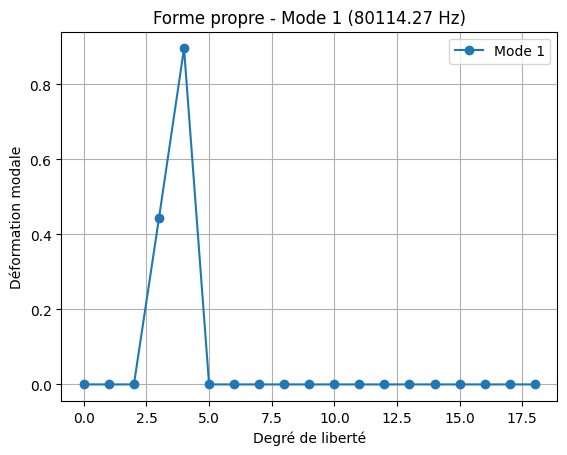

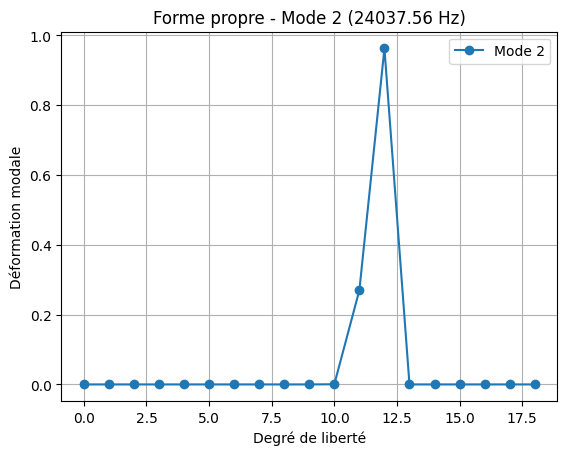

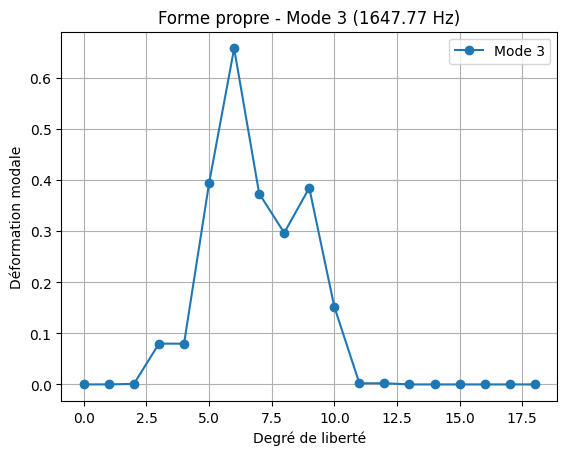

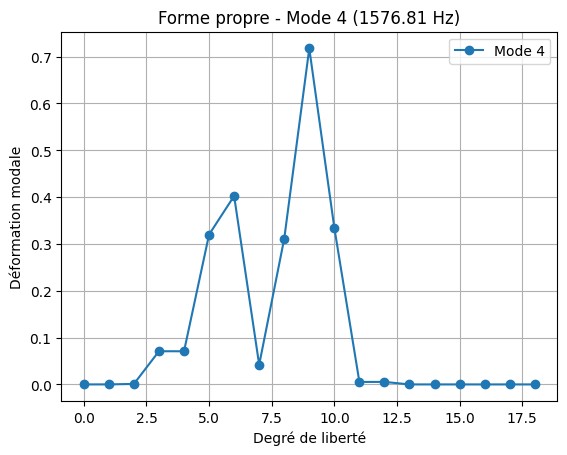

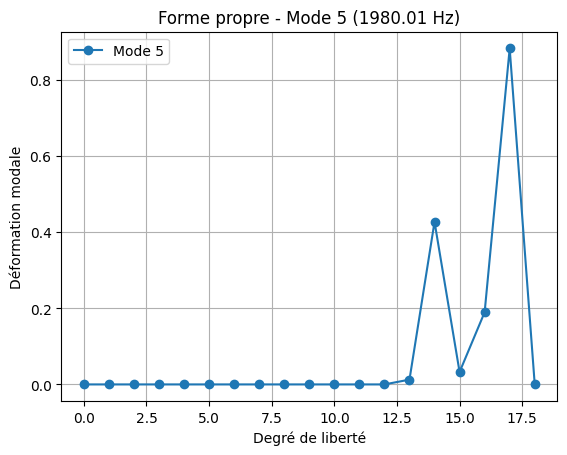

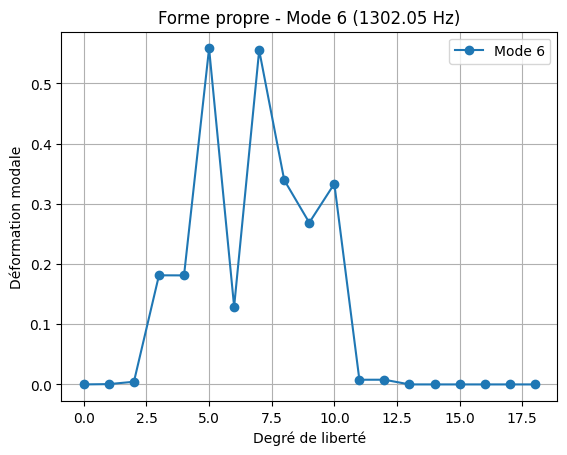

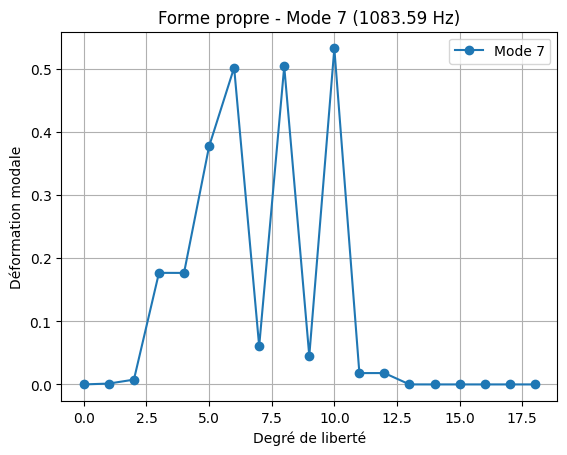

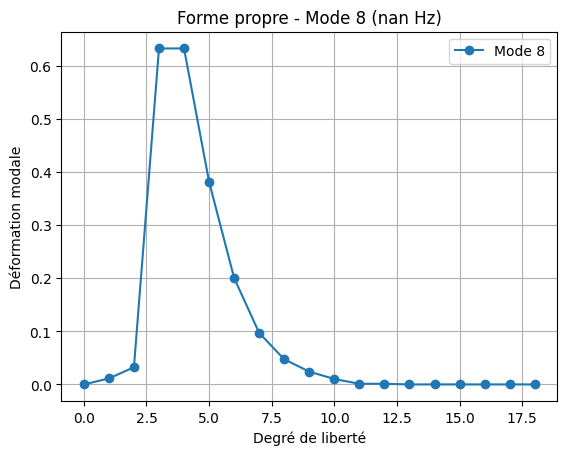

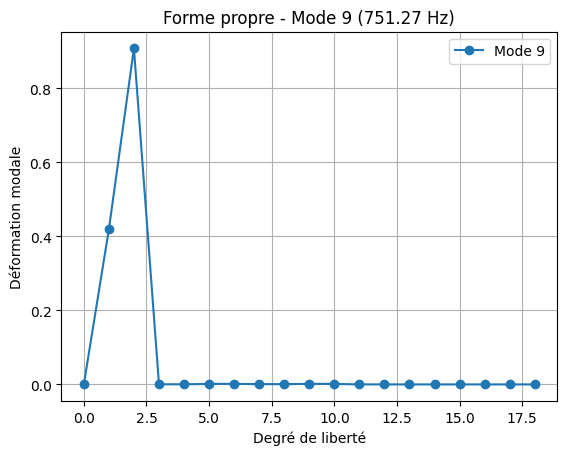

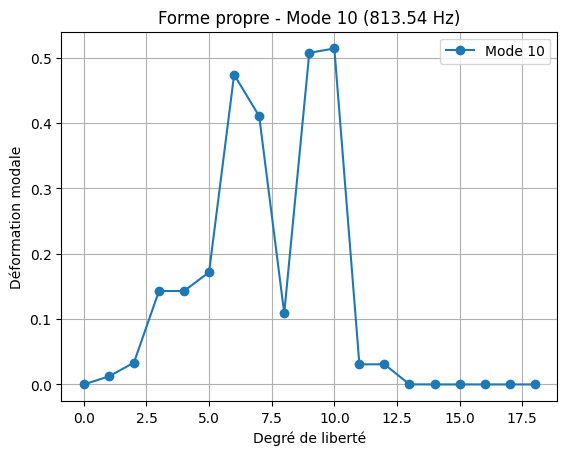

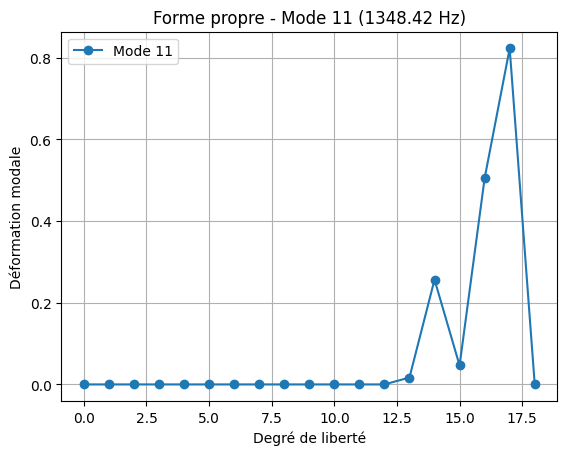

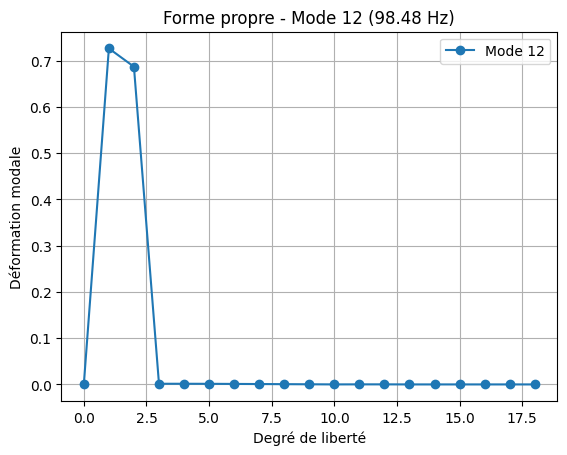

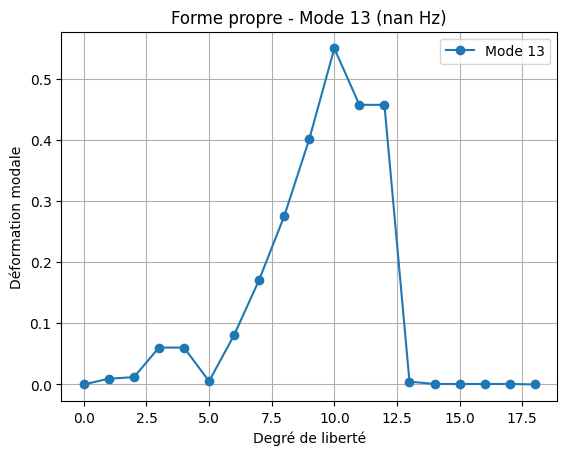

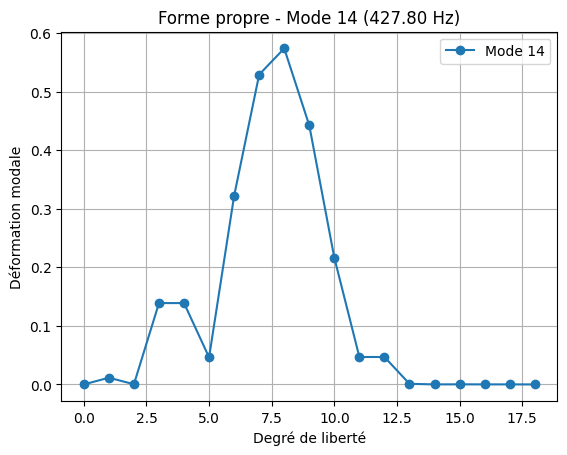

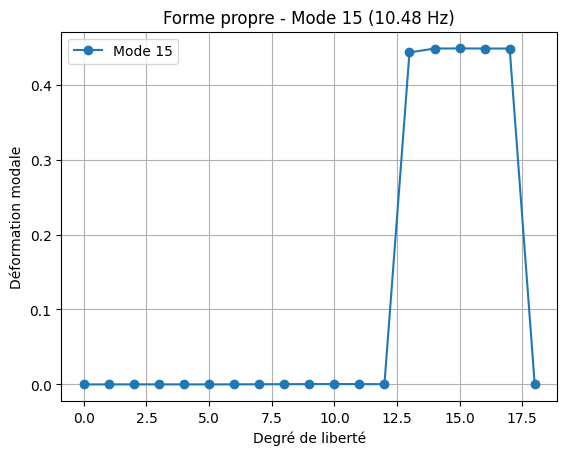

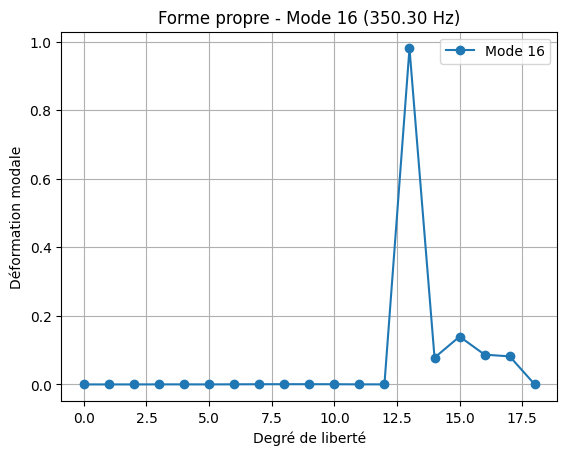

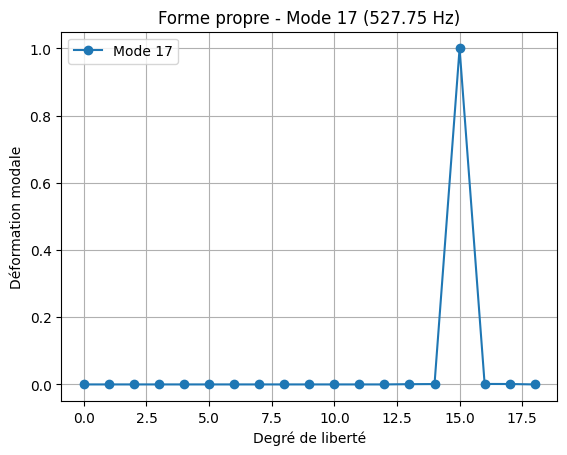

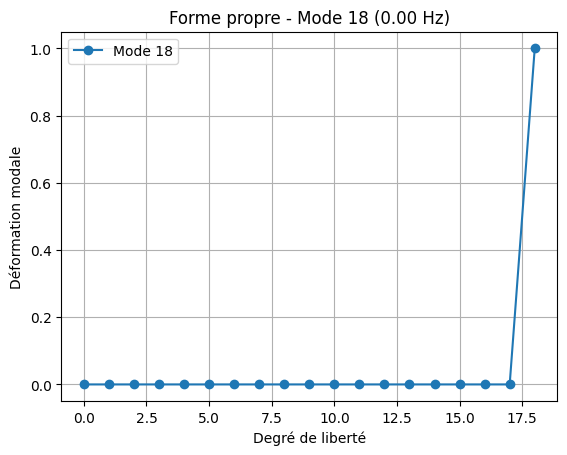

In [150]:
DeformeeModale(J, K)

In [151]:
repFrequence(J, K, F, 0, 2000, Nddl)

LinAlgError: Singular matrix